In [1]:
import numpy as np
from python.analysis import Plots
Plots.plt.style.use("default")
Plots.plt.style.use("ggplot")

Measueing pi:

The definition for the area of a circle is

$$
A_{c} = \pi r_{c}^{2}
$$

so by measuring $r_{c}$ and $A_{c}$ you can compute $\pi$. to measure the area one would use the formula, but instead we can look at the problem in a different way. Let us compare the ratio of the square  with $r_{s}$ to a circe:

$$
R = \frac{\pi r_{c}^{2}}{r_{s}^2}
$$

and when $r_{s}$ = $r_{c}$, $R = \pi$. To indirectly measure this ratio we can do the following:
 - create a target with a circle overlapping a sqaure with $r_{s} = 2 r_{c}$.
 - throw darts randomly at the target
 - count the number of darts which are in the circle and count the number in the square, and the ratio of these numbers are directly proportional to the $R$.

Note now because $r_{s} = 2 r_{c}$ the equation is modified:

$$
R = \frac{4\pi r_{c}^{2}}{r_{s}^2}
$$


In [2]:
def count_in_circle(throws, r_c):
    r = (throws[0]**2 + throws[1]**2)**2
    return sum(r < r_c)


def count_in_square(throws, r_s):
    return sum((throws[0] < r_s) & (throws[1] < r_s))


def R(throws, r_s, r_c):
    return 4 * count_in_circle(throws, r_c)/count_in_square(throws, r_s)


def sigma_r_stat(throws, r_s, r_c):
    n_c = count_in_circle(throws, r_c)
    n_s = count_in_square(throws, r_s)
    return 4* n_c/n_s * (1/n_c + 1/n_s)**0.5

In [3]:
def throw_bias(x, y):
    return [[x], [y]]

In [4]:
r_s = 2
r_c = 1
n_throws = 1000

bx = -0.75
by = 0.75

throws = r_s * (np.random.random([2, n_throws]) - 0.5) + throw_bias(bx, by) # where did the dart land

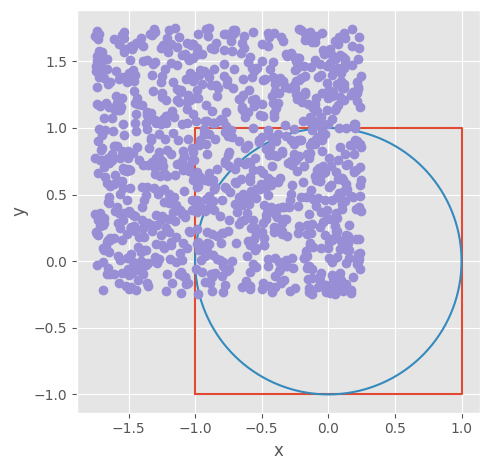

In [5]:
def visualise():
    Plots.Plot(np.array([-0.5, 0.5, 0.5, -0.5, -0.5])*r_s, np.array([-0.5, -0.5, 0.5, 0.5, -0.5])*r_s, xlabel = "x", ylabel = "y")
    theta = np.linspace(0, 2* np.pi, 1000)
    Plots.Plot(r_c * np.sin(theta), r_c * np.cos(theta), newFigure = False)
    Plots.Plot(throws[0], throws[1], marker = "o", linestyle = "", newFigure = False)
    Plots.plt.gca().set_aspect('equal')
    return

visualise()

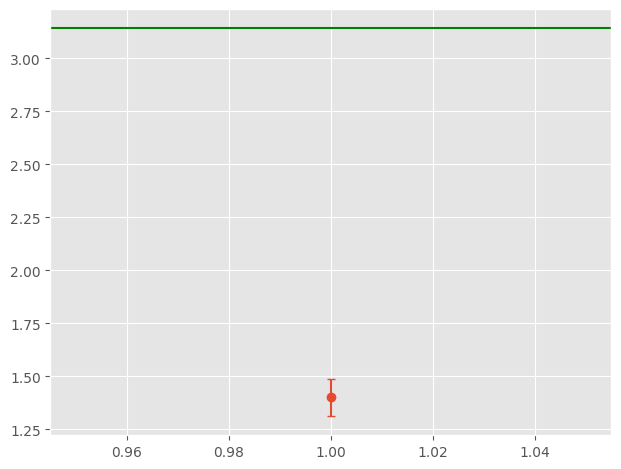

In [6]:
r = R(throws, r_s, r_c)
sigma_r = sigma_r_stat(throws, r_s, r_c)

Plots.Plot(1, r, yerr = sigma_r, marker = "o")
Plots.plt.axhline(np.pi, color = "green")

# Estimate bias in the throws

In [7]:
def estimate_bias(x):
    return np.mean(x), np.std(x)/(len(x - 1))**0.5

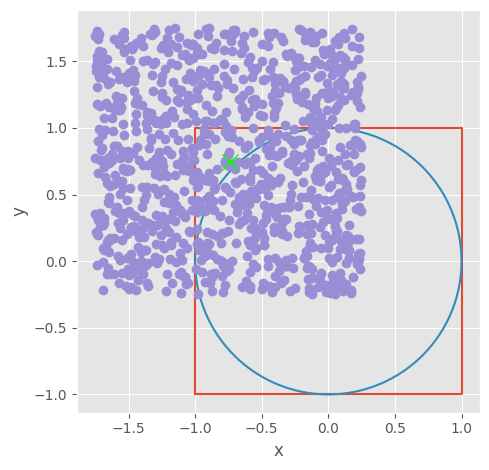

In [8]:
est_bias_x  = estimate_bias(throws[0])
est_bias_y  = estimate_bias(throws[1])
visualise()
Plots.Plot(est_bias_x[0], est_bias_y[0], xerr = est_bias_x[1], yerr = est_bias_y[1], newFigure = False, marker = "x", color = "lime", markersize = 12)

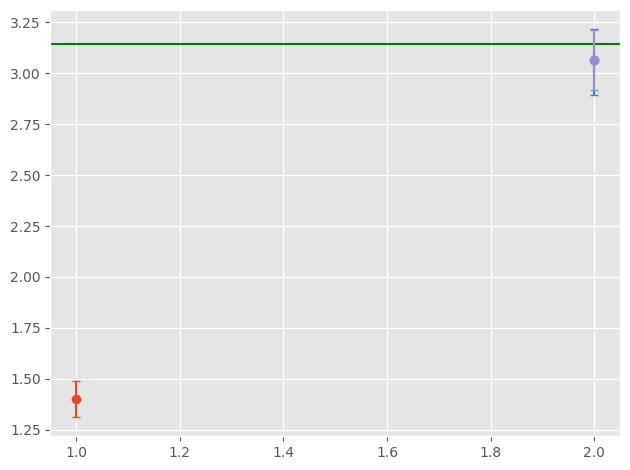

In [9]:
bias_corrected_r = R(throws - throw_bias(est_bias_x[0], est_bias_y[0]), r_s, r_c)
sigma_bias_corrected_r_stat = sigma_r_stat(throws - throw_bias(est_bias_x[0], est_bias_y[0]), r_s, r_c) # this sigma will change based on the upper and lower bounds as well...
bias_corrected_r_upper = R(throws - throw_bias(est_bias_x[0] + est_bias_x[1], est_bias_y[0] + est_bias_y[1]), r_s, r_c)
bias_corrected_r_lower = R(throws - throw_bias(est_bias_x[0] - est_bias_x[1], est_bias_y[0] - est_bias_y[1]), r_s, r_c)


Plots.Plot(1, r, yerr = sigma_r, marker = "o")
Plots.plt.axhline(np.pi, color = "green")
Plots.Plot(2, bias_corrected_r, yerr = [ [sigma_bias_corrected_r_stat + abs(bias_corrected_r - bias_corrected_r_lower)], [sigma_bias_corrected_r_stat + abs(bias_corrected_r - bias_corrected_r_upper)]], marker = "o", newFigure = False)
Plots.Plot(2, bias_corrected_r, yerr = sigma_bias_corrected_r_stat, marker = "o", newFigure = False)


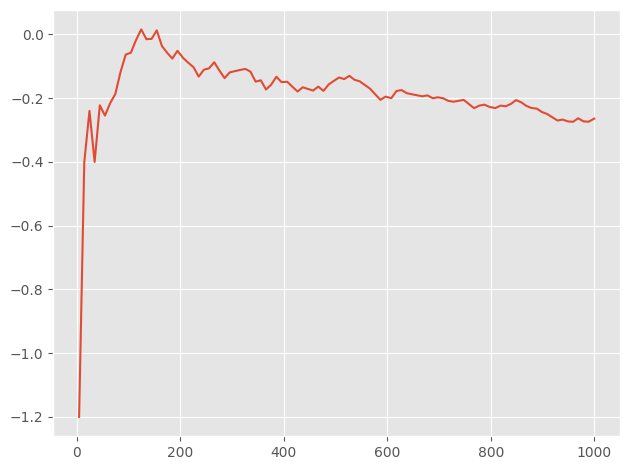

In [10]:
corrected_throws = throws - throw_bias(est_bias_x[0], est_bias_y[0])
bias_corrected_r = R(corrected_throws[:, 0:10], r_s, r_c)

n = np.linspace(5, len(corrected_throws[0]), 100, dtype = int)
out = []
for i in n:
    out.append(abs(bias_corrected_r) - R(corrected_throws[:, 0:i], r_s, r_c))

Plots.Plot(n, out)

# Fischer discriminant

In [11]:
class Fischer:
    def __init__(self, x1, x2):
        self.x1 = x1
        self.x2 = x2

    def Run(self, c1, cutsom_offset : float = 0):
        mu1 = np.array([np.mean(self.x1[c1]), np.mean(self.x2[c1])])
        mu2 = np.array([np.mean(self.x1[~c1]), np.mean(self.x2[~c1])])

        cov1 = np.cov([self.x1[c1], self.x2[c1]])
        cov2 = np.cov([self.x1[~c1], self.x2[~c1]])

        w = np.matmul(np.linalg.inv(cov1 + cov2), (mu1 - mu2))

        f = (w[0] * self.x1) + (w[1] * self.x2)
        w0 = np.median(f) + cutsom_offset
        f -= w0
        f_efficiency = sum((f > 0) == c1) / len(c1)

        print(f"{w=}")
        print(f"{w0=}")
        print(f"{f_efficiency=}")

        x = np.linspace(np.min(self.x1), np.max(self.x1), 10)
        Plots.Plot(x, 0.5 + 2 * x, color = "black", linestyle = "--", label = "exact")

        Plots.Plot(self.x1[c1], self.x2[c1], newFigure = False, marker = "o", linestyle = "", markersize = 3, xlabel = "x1", ylabel = "x2", alpha = 0.5, label = "A")
        Plots.Plot(self.x1[~c1], self.x2[~c1], newFigure = False, marker = "o", linestyle = "", markersize = 3, alpha = 0.5, label = "B")

        Plots.Plot(mu1[0], mu1[1], newFigure = False, marker = "X", linestyle = "", color = "C0", markersize = 12, label = "$\mu_{A}$")
        Plots.Plot(mu2[0], mu2[1], newFigure = False, marker = "X", linestyle = "", color = "C1", markersize = 12, label = "$\mu_{B}$")

        Plots.Plot(self.x1[c1], f[c1], marker = "o", linestyle = "", xlabel = "x1", ylabel = "F", markersize = 3)
        Plots.Plot(self.x1[~c1], f[~c1], newFigure = False, marker = "o", linestyle = "", markersize = 3)
        Plots.plt.axhline(0, label = "Fischer cut", color = "black", linestyle = "--")
        return

In [12]:
n = int(1E4)
x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 3, n)

w=array([ 1.25205094, -0.62119287])
w0=0.030460183391668283
f_efficiency=0.9344


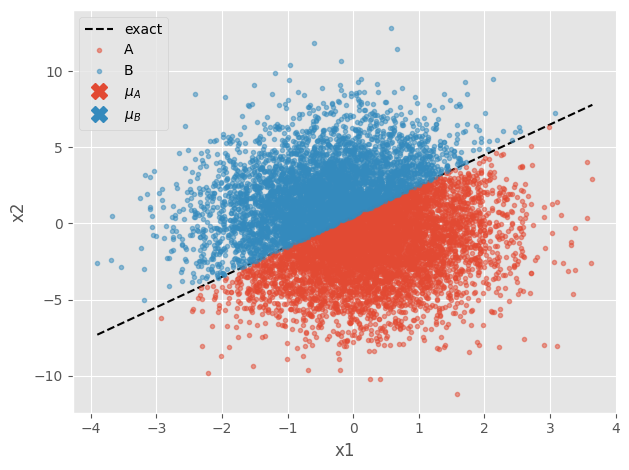

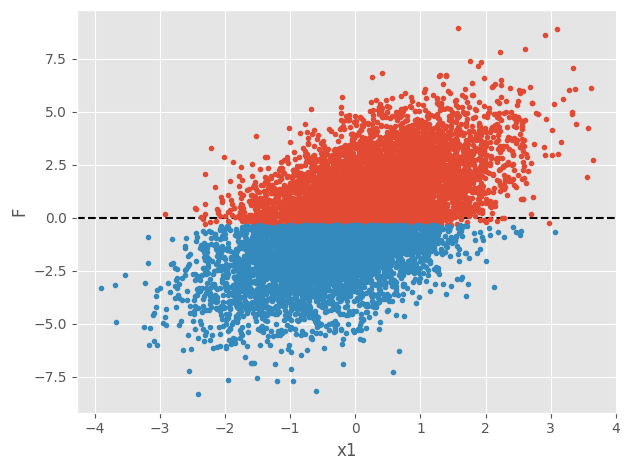

In [13]:
c1 = (-2 * x1 + x2) < 0.5 #* use fischer discriminant for this case!
fischer = Fischer(x1, x2)
fischer.Run(c1)

w=array([1.27114477, 0.33625633])
w0=-0.029149551577231814
f_efficiency=0.6293


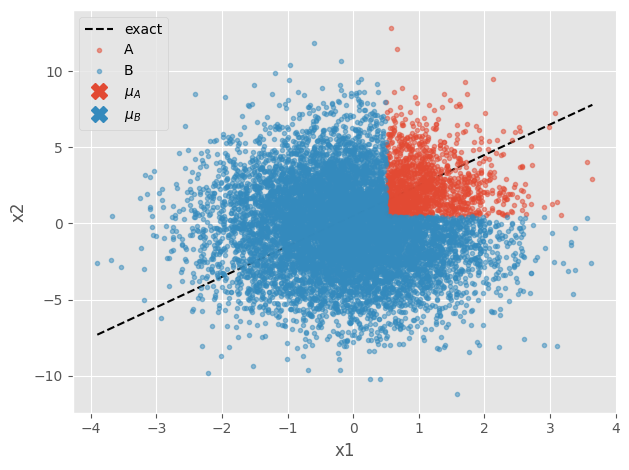

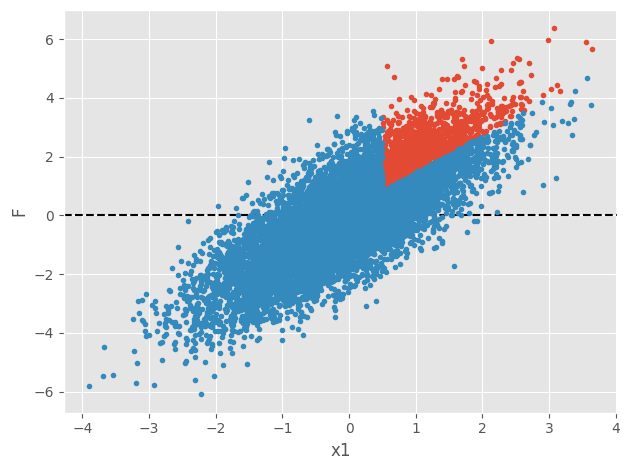

In [14]:
c1 = (x1 > 0.5) & (x2 > 0.5) #! don't use fischer discriminant for this case!
fischer = Fischer(x1, x2)
fischer.Run(c1)

# ABCD background subtraction

$$
N^{b}_{D} = N^{b}_{B}\frac{N^{b}_{C}}{N^{b}_{A}}
$$

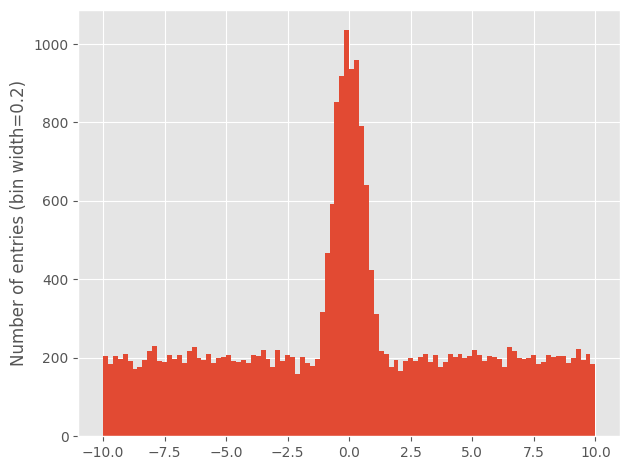

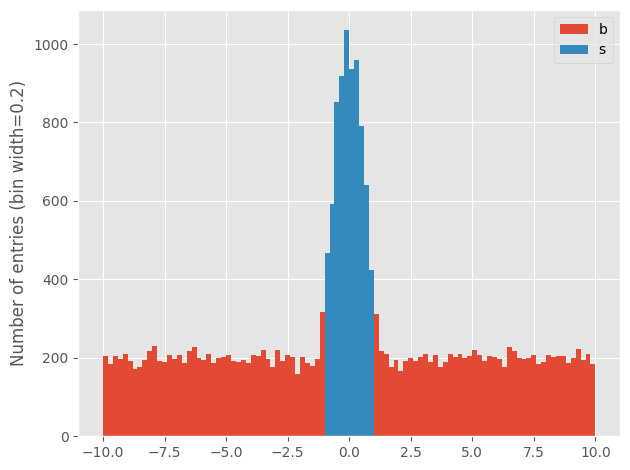

In [15]:
n = int(1E5)

def g(x):
    return np.exp(-x**2)

def u(x):
    return [0.2]*len(x)

x = np.random.uniform(-10, 10, n)
p = np.random.random(n)
a = (p < g(x)) | (p < u(x))
d = x[a]


q1, q2 = np.random.randint(0, 2, [len(d), 2], dtype = bool).T # tagging events

def regions():
    return {"A" : (q1 == 0) & (q2 == 0), "B" : (q1 == 0) & (q2 == 1), "C" : (q1 == 1) & (q2 == 0), "D" : (q1 == 1) & (q2 == 1)}


s = abs(d) < 1
Plots.PlotHist(d)
Plots.PlotHist([d[~s], d[s]], label = ["b", "s"], stacked = True)
r = regions()

0 A
[ 0.48482628  0.34446126 -0.44649947 ...  0.21619913 -0.31496064
  0.68179428]
1 B
[-0.78006616 -0.28983183  0.08616165 ...  0.39950184 -0.2928465
 -0.19843496]
2 C
[-0.85105047  0.0454066  -0.28176281 ...  0.36709506 -0.89630207
  0.92535641]
3 D
[ 0.06469046  0.35519065  0.26357262 ... -0.7385379   0.09264375
  0.73337774]


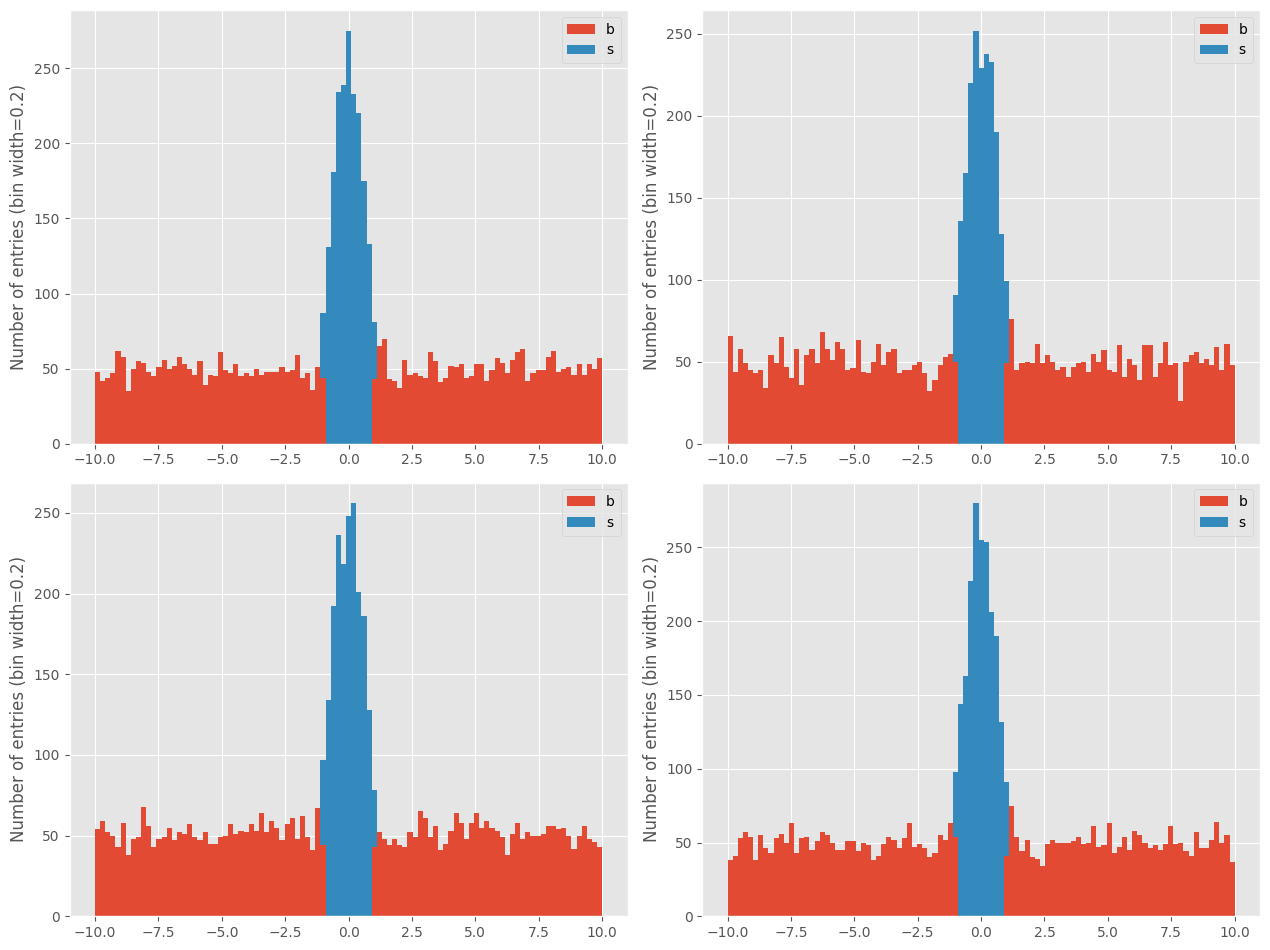

In [16]:
bins = np.linspace(-10, 10, 100) # fix the binning

for i, j in Plots.IterMultiPlot(r):
    print(i, j)
    print(d[r[j] & s])
    Plots.PlotHist([d[r[j] & ~s], d[r[j] & s]], label = ["b", "s"], bins = bins, stacked = True, newFigure = False)


# estimate backgrounds

{'A': (48.96052631578947, 1.0162609123254671), 'B': (49.0921052631579, 1.2247703159653265), 'C': (50.81578947368421, 1.0963592903077606), 'D': (50.952354347303356, 1.9856739290522063)}


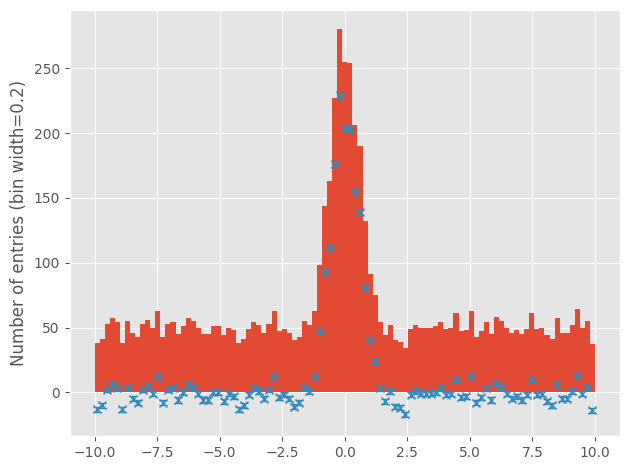

In [18]:
def estimate_background(data):
    background = abs(data) > 2.5
    counts = np.histogram(data[background], bins)[0]
    counts = counts[counts != 0]
    return np.mean(counts), np.std(counts) / np.sqrt(len(counts)-1) 


def ABCD_method(data, reg):
    n_b = {i : estimate_background(data[reg[i]]) for i in ["A", "B", "C"]}

    n_D = (n_b["C"][0]/n_b["A"][0]) * n_b["B"][0] # ABCD subtraction

    n_D_e = n_D * sum([(n_b[i][1]/n_b[i][0])**2 for i in ["A", "B", "C"]])**0.5
    n_b["D"] = (n_D, n_D_e)
    print(n_b)
    return n_b["D"]

n_background = ABCD_method(d, r)
signal_data_hist = np.histogram(d[r["D"]], bins = bins)

centers = (signal_data_hist[1][1:] + signal_data_hist[1][:-1]) / 2

Plots.PlotHist(d[r["D"]], bins = bins)
Plots.Plot(centers, signal_data_hist[0] - n_background[0], yerr = n_background[1], newFigure = False, marker = "x", linestyle = "")

# Plots.plt.hist(signal_data_hist[1][:-1], bins = signal_data_hist[1], weights = signal_data_hist[0] - n_background[0])


# pyhf

In [11]:
%load_ext autoreload
%autoreload 2

import pyhf
import numpy as np
from python.analysis import Plots
from python.analysis.cross_section import SetPlotStyle, Toy, BackgroundFit
from apps.cex_toy_parameters import PlotCorrelationMatrix

from rich import print
import os
from pathos.pools import ProcessPool

SetPlotStyle(True, 100)
pyhf.set_backend(backend = "numpy", custom_optimizer = "minuit")

def MakePull(model, observations, normalisation):
    result = BackgroundFit.Fit(observations, model, verbose = False)
    return ((normalisation * result[0:4, 0]) - 1) / (normalisation * result[0:4, 1])


def CalculatePulls(n_experiments, n_regions, model, max_cpu : int = os.cpu_count()-2):

    batches = int(n_experiments/max_cpu)
    remainder = n_experiments % max_cpu

    pulls = []
    for i in range(batches + 1):
        if i == batches:
            cpus = remainder
        else:
            cpus = max_cpu
        if cpus == 0: continue
        pools = ProcessPool(nodes = cpus)
        observations = [BackgroundFit.GenerateObservations(CreateDataSet(12, n_regions, n_background, 2500, bins), n_regions, model, verbose = False) for i in range(cpus)]
        pulls.extend(pools.map(MakePull, observations))
    return np.array(pulls)


def CreateDataSet(seed : int, n_regions : int, n_background : int, n_data : int, bins : list):
    rng = np.random.default_rng(seed)
    mu =    [0, 0.5, 1, 2]
    sigma = [1, 0.5, 3, 1.4]
    # mu = rng.random()
    # sigma = rng.random()

    sample_fractions = rng.random(size = [n_regions, n_background + 1])
    sample_fractions = sample_fractions / np.sum(sample_fractions, axis = 1)[:, np.newaxis]
   
    output = {}
    for i in range(n_regions):
        output[f"region_{i}"] = [np.random.normal(mu[j], sigma[j], int(n_data * sample_fractions[i][j])) for j in range(n_background + 1)]
        output[f"region_{i}_binned"] = [np.histogram(i, bins = bins)[0] for i in output[f"region_{i}"]]
        output[f"region_{i}_combined"] = np.sum(output[f"region_{i}_binned"], axis = 0)

    return output


def PlotSignal(data, n_regions, result, model):
    mu = result[model.config.poi_index]
    print(f"{mu=}")
    centers = (bins[1:] + bins[:-1])/2

    for n in Plots.MultiPlot(n_regions):
        Plots.PlotHist(data[f"region_{n}"], stacked = True, bins = bins, newFigure = False)
        Plots.Plot(centers, mu[0] * model.spec["channels"][n]["samples"][0]["data"], yerr = mu[1] * model.spec["channels"][n]["samples"][0]["data"], color = "black", marker = "x", linestyle = "", newFigure = False)


def MakePlots(data, result, n_regions, n_background, model):
    config_order = {"mu" : 0}
    config_order.update({f"bkg_{i}" : i + 1 for i in range(n_background)})
    for n in Plots.MultiPlot(n_regions):
        Plots.PlotHist(data[f"region_{n}"], stacked = True, bins = bins, label = [f"mc:{i}" for i in config_order], newFigure = False)
        counts = np.zeros(len(bins) - 1)
        for p in config_order:
            model_index = model.config.par_map[p]["slice"].start
            config_index = config_order[p]
            counts = counts + model.spec["channels"][n]["samples"][config_index]["data"]
            Plots.Plot(centers, result[model_index][0] * counts, yerr = result[model_index][1] * counts, label = f"data:{p}", marker = "x", linestyle = "", newFigure = False)

In [12]:
toy = Toy("work/2023/toys/xs_toy_1GeV_gaussian_60MeV.hdf5", True)
toy.df.head()

,KE_init,KE_int,z_int,inclusive_process,exclusive_process,absorption,charge_exchange,double_charge_exchange,pion_production,quasielastic,...,reco_regions_charge_exchange,reco_regions_single_pion_production,reco_regions_pion_production,truth_regions_absorption,truth_regions_charge_exchange,truth_regions_single_pion_production,truth_regions_pion_production,z_int_smeared,KE_init_smeared,KE_int_smeared
0,909.190834,889.359165,9.0,total_inelastic,absorption,True,False,False,False,False,...,False,False,False,True,False,False,False,21.638652,902.895740,998.755033
1,904.330491,837.310713,30.5,total_inelastic,quasielastic,False,False,False,False,True,...,False,False,False,False,False,True,False,15.866633,899.539169,805.964996
2,902.235948,798.076715,47.5,total_inelastic,quasielastic,False,False,False,False,True,...,False,True,False,False,False,True,False,48.509617,844.991826,820.754454
3,785.834295,768.421353,8.0,total_inelastic,quasielastic,False,False,False,False,True,...,False,False,False,False,False,True,False,7.955258,758.439491,703.912846
4,876.636799,755.354927,55.5,total_inelastic,pion_production,False,False,False,True,False,...,False,False,False,False,False,False,True,57.181669,909.378183,640.846427


In [13]:
toy_model_input = toy.df.iloc[:int(len(toy.df)/2),:]
toy_observed = toy.df.iloc[int(len(toy.df)/2):,:]

In [14]:
bins = np.linspace(0, 1050, 12)
model_input_data = []
for c in toy_model_input.filter(regex = "reco_regions"):
    tmp = []
    for s in toy_model_input.filter(regex = "truth_regions"):
        tmp.append(np.histogram(toy_model_input.KE_int[toy_model_input[c] & toy_model_input[s]], bins = bins)[0])
    model_input_data.append(tmp)

In [15]:
model = BackgroundFit.CreateModel(len(model_input_data), model_input_data, True)
BackgroundFit.PrintModelSpecs(model)

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 11, 'channel_1': 11, 'channel_2': 11, 'channel_3': 11}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor'), ('sample_stat_err_0', 'staterror'), ('sample_stat_err_1', 'staterror'), ('sample_stat_err_2', 'staterror'), ('sample_stat_err_3', 'staterror')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3', 'sample_stat_err_0', 'sample_stat_err_1', 'sample_stat_err_2', 'sample_stat_err_3']
  nauxdata: 176
   auxdata: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [16]:
toy_observed_binned = []
for c in toy_observed.filter(regex = "reco_regions"):
    toy_observed_binned.append(np.histogram(toy_observed.KE_int[toy_observed[c]], bins = bins)[0])
observed = BackgroundFit.GenerateObservations(toy_observed_binned, model)

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=a

In [17]:
result = BackgroundFit.Fit(observed, model)

model.config.poi_index=0
result=array([[0.97005105, 0.01306415],
       [1.02032957, 0.02157147],
       [1.14040633, 0.01521398],
       [1.03893278, 0.03175997],
       [1.02732102, 0.03024446],
       [0.99950701, 0.01791826],
       [0.98195415, 0.01415864],
       [0.99502788, 0.01092693],
       [0.996765  , 0.00921869],
       [1.00354424, 0.00807455],
       [1.00095027, 0.00696089],
       [1.00277078, 0.00613495],
       [1.00311122, 0.00625321],
       [0.99997792, 0.01021417],
       [1.01544157, 0.04099818],
       [1.        , 0.        ],
       [0.85260017, 0.97541218],
       [0.92240917, 0.44095633],
       [1.01987146, 0.980719  ],
       [0.92649645, 0.57251691],
       [0.96996297, 0.57320664],
       [0.99496467, 0.37658501],
       [0.98496495, 0.37676507],
       [1.00103215, 0.33248427],
       [0.99849568, 0.70037787],
       [1.        , 0.        ],
       [1.03716982, 0.06566247],
       [0.98375058, 0.037881  ],
       [0.98699758, 0.03028488],
       [0.9

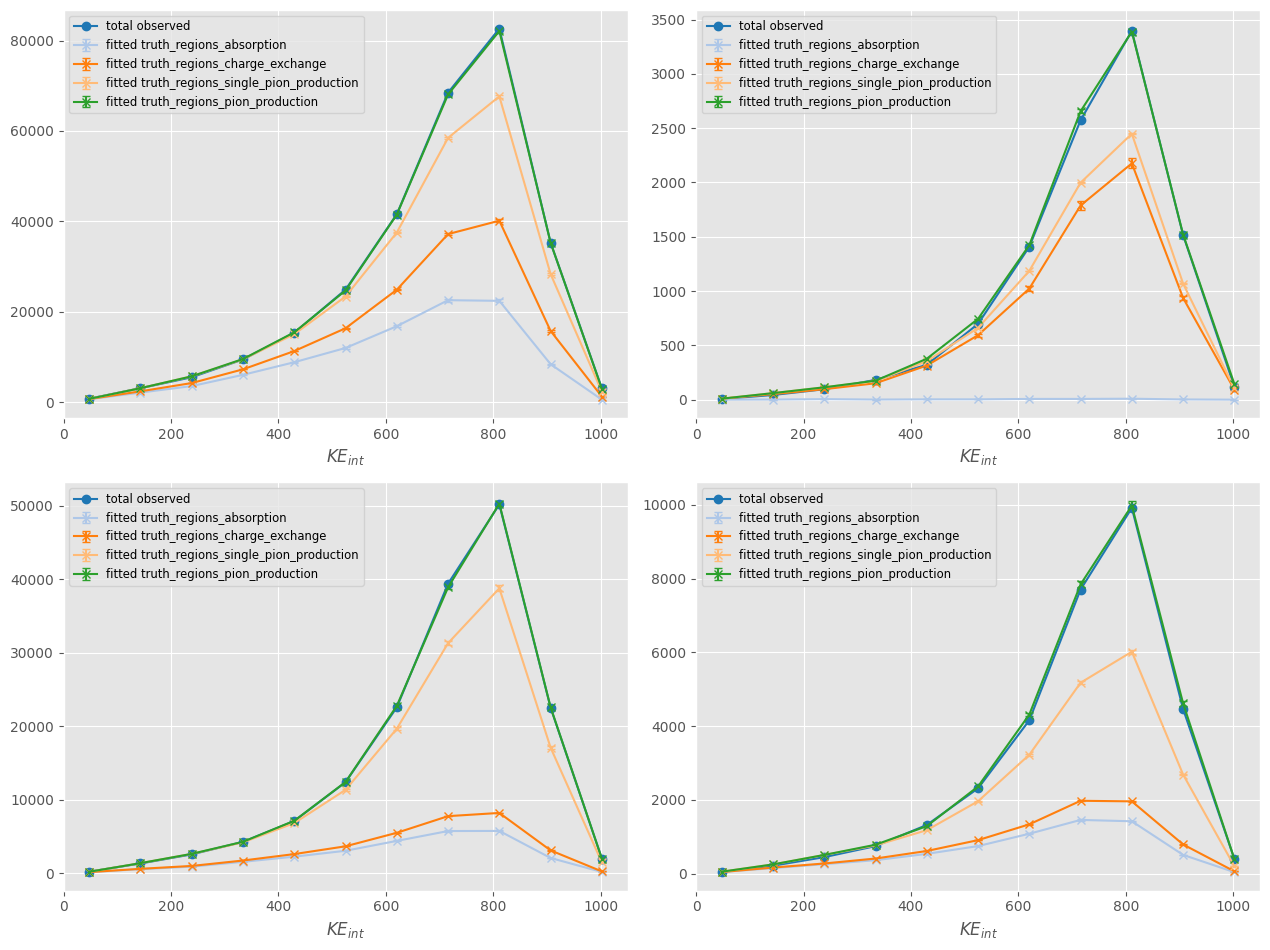

In [18]:
x = (bins[1:] + bins[:-1])/2
for i, d in Plots.IterMultiPlot(toy_model_input.filter(regex = "reco_regions").columns):
    Plots.Plot(x, toy_observed_binned[i], marker = "o", label = "total observed", newFigure = False)

    labels = toy_model_input.filter(regex = "truth_regions").columns

    plot_data = [np.histogram(toy_model_input[toy_model_input[d] & toy_model_input[m]].KE_int, bins = bins)[0] for m in toy_model_input.filter(regex = "truth_regions")]
    counts = np.zeros(len(plot_data[0]))
    for e, (i, mu) in enumerate(zip(plot_data, result)):
        counts = counts + (i * mu[0])
        Plots.Plot(x, counts, yerr = i * mu[1], marker = "x", xlabel = "$KE_{int}$", label = f"fitted {labels[e]}", newFigure = False)

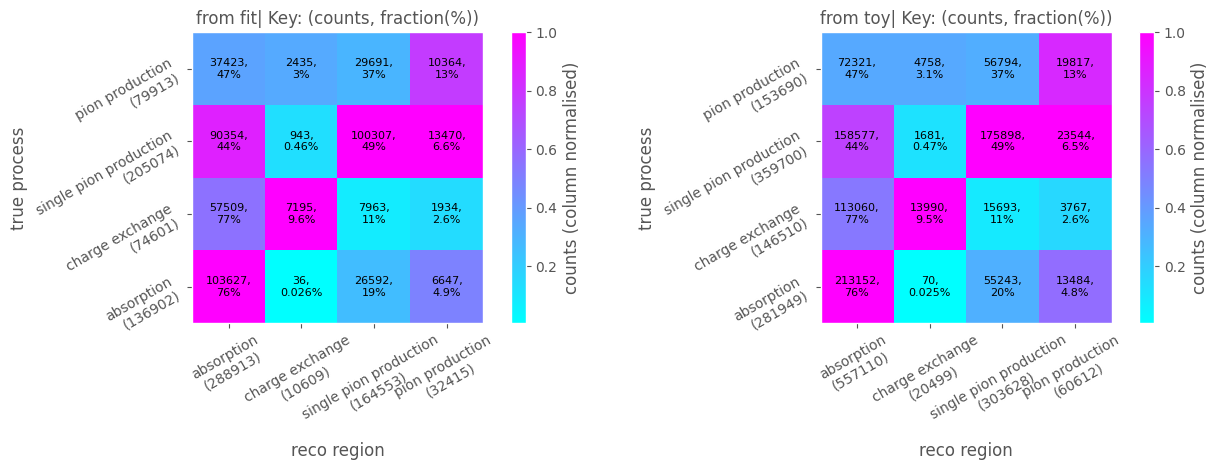

In [26]:

plot = Plots.MultiPlot(2)
next(plot)
counts_matrix = BackgroundFit.GetPredictedCorrelationMatrix(model, result[0:4, 0])
PlotCorrelationMatrix(counts_matrix, toy.truth_region_labels, toy.reco_region_labels, title = "from fit", newFigure = False)
next(plot)
counts = toy.GetCorrelationMatrix(toy.df)
PlotCorrelationMatrix(counts, toy.truth_region_labels, toy.reco_region_labels, title = "from toy", newFigure = False)


- make table for mu with errors

- Make large toy data set for defining the model (1E7)
- Make large toy dat set to fit to (1E7)
- Make toy dataset with same number of true beam pi+ (1E5)